# Least Square Classifier

In [17]:
import itertools
import functools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [18]:
def combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    return functools.reduce(lambda x, y: x * y, items)

def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]

    features = [np.ones(len(x))] # A list of np-arrays with all 1.

    for degree in range(1, degree + 1):
        for item in combinations(x.T, degree):
            features.append(compute_new_features(item))
            
    return np.asarray(features).T

## Classification on Data
Create the input data. This function can add more classes to the output label, and/or add outliers to the input data.

In [19]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1,2) - 1  # # reshape(-1,2) here == reshape(25, 2)
    x1 = np.random.normal(size=50).reshape(-1,2) + 1
    if add_outliers:  # add 5 (pairs of (x, y)) outliers
        x_1 = np.random.normal(size=10).reshape(-1,2) + np.array([5., 10.])
        return np.concatenate((x0, x1, x_1)), np.concatenate((np.zeros(25), np.ones(30))).astype(int)
    if add_class: #add 25 (pairs of (x, y) additional data)
        x2 = np.random.normal(size=50).reshape(-1,2) + 2
        return np.concatenate((x0, x1, x2)), np.concatenate((np.zeros(25), np.ones(25), 2 + np.zeros(25))).astype(int)
    return np.concatenate((x0, x1)), np.concatenate((np.zeros(25), np.ones(25))).astype(int)

## Label Transfomer

In [20]:
class LabelTransformer(object):
    def __init__(self, n_classes:int=None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)
    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices:np.ndarray):
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot:np.ndarray):
        return np.argmax(onehot, axis=1)

In [21]:
l = LabelTransformer(2)
print(l.n_classes)
print(l.encoder[[0,1,0,1]])

2
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


**Here's an alternative (and much simpler) logic for encoder**

In [22]:
def encode(arr):
    encoded = np.zeros((arr.size, arr.max() + 1))
    encoded[np.arange(arr.size), arr] = 1
    return encoded

arr = np.array([1, 2, 3,4])
encode(arr)

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [23]:
def preprocess(add_class=False, add_outliers=False, degree=1):
    x, y = create_toy_data(add_outliers, add_class)
    x_poly = polynomial_transform(x, degree=degree)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y) 
    y_train_trans = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)
    return x_train , x_test, y_train, y_test, y_train_trans, y_test_trans 

In [24]:
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train, labels, lsc, degree=1):
    f = plt.figure(figsize=(8,8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])
    
    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)) 
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc.predict(x_test_poly)
    
    sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.gca().set_aspect('equal', adjustable='box')

## Least Square Classification Algorithm - `LeastSquareClassification()`

In [32]:
 class LeastSquareClassification(object):
    def __init__(self):
        self.t0=20
        self.t1=1000
  
    def predict(self,X):
        return np.argmax(X @ self.w, axis=-1)

    def predict_internal(self,X):
        return X @ self.w
  
    def loss(self,X,y,reg_rate):
        y_hat = self.predict_internal(X)
        err = y_hat - y
        return (1/2) * (err.T @ err) + (reg_rate / 2) * (self.w.T @ self.w)

    def fit(self,X, y, reg_rate=0):
        self.w = np.linalg.solve(X.T @ X + reg_rate * np.eye(X.shape[-1]), X.T@y)
        print(X.shape, y.shape, self.w.shape)
        return self.w
  
    def calculate_gradient(self, X, y, reg_rate):
        y_hat = self.predict_internal(X)
        return X.T @ (y_hat - y) + reg_rate * self.w
  
    def weight_updates(self, grad,lr):
        return (self.w - lr*grad)
  
    def learning_schedule(self, t):
        return self.t0 / (t + self.t1)
  
    def gd(self, X, y, num_epochs, lr, reg_rate):
        self.w = np.zeros((X.shape[-1], y.shape[-1]))
        self.w_all = []
        self.err_all = []
        for i in np.arange(0, num_epochs):
          djdw = self.calculate_gradient(X, y, reg_rate)
          self.w_all.append(self.w)
          self.err_all.append(self.loss(X, y, reg_rate))
          self.w = self.weight_updates(djdw, lr)
        return self.w
  
    def sgd(self, X, y, num_epochs, reg_rate):
        self.err_all = []
        self.w_all = []
        self.w=np.zeros((X.shape[-1], y.shape[-1]))
        t=0
        for epoch in range(num_epochs):
          for iter in range(X.shape[0]):
            t = t+1
            random_index = np.random.randint(X.shape[0])
            x1 = X[random_index:random_index+1]
            y1 = y[random_index:random_index+1]

            self.w_all.append(self.w)
            self.err_all.append(self.loss(x1, y1, reg_rate))

            djdw = self.calculate_gradient(x1, y1, reg_rate)
            self.w = self.weight_updates(djdw, self.learning_schedule(t))
        return self.w

In [33]:
x_train , x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()
x_train.shape, y_train.shape

((37, 3), (37,))

In [34]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(37, 3) (37, 2) (3, 2)


array([[ 0.49727914,  0.50272086],
       [-0.14539703,  0.14539703],
       [-0.1942026 ,  0.1942026 ]])

In [35]:
assert x_train.shape[0] == y_train.shape[0], "Not enough labels for all training samples"

assert x_test.shape[0] == y_test.shape[0], "Not enough labels for all test samples"

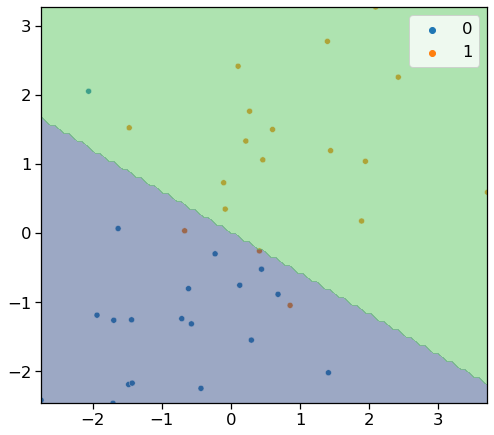

In [29]:
visualize_model(x_train, y_train, lsc)

In [36]:
def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'r-')

### Gradient Descent

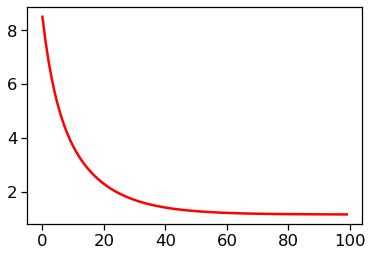

In [37]:
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 0.001)
plot_learning_curve(lsc.err_all)

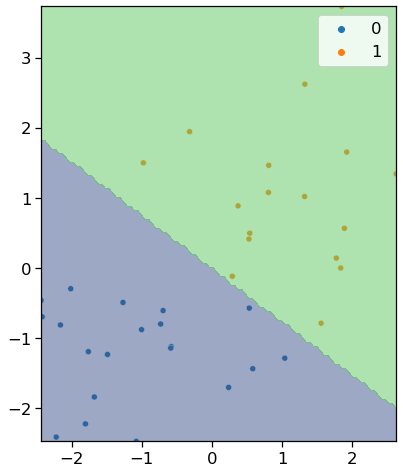

In [38]:
visualize_model(x_train, y_train, lsc)

### Stochastic Gradient Descent

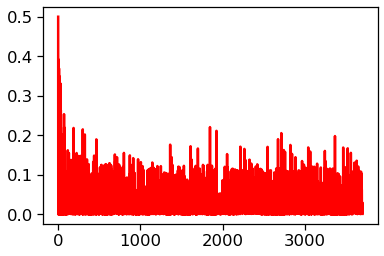

In [40]:
lsc.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc.err_all)

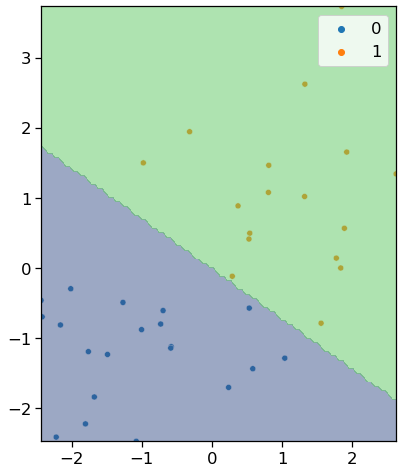

In [42]:
visualize_model(x_train, y_train, lsc)

## Model Evaluation

In [43]:
y_test_hat = lsc.predict(x_test)

In [45]:
tp = np.where((y_test == 1) & (y_test_hat == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_test_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_test_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_hat == 0), 1, 0).sum()

tp, tn, fn, fp

(8, 4, 0, 1)

### Evaluation Metrics

In [46]:
def precision(tp, fp):
    if (tp + fp) == 0:
        return NaN
    return tp / (tp + fp)

def recall(tp, fn):
    if (tp + fn) == 0:
        return NaN
    return tp / (tp + fn)

def accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

def f1_score(pr, r):
    return 2 * ((pr * r) / (pr + r))

In [47]:
pr = precision(tp, fp)
r = recall(tp, fn)
pr, r, accuracy(tp, tn, fp, fn), f1_score(pr, r)

(0.8888888888888888, 1.0, 0.9230769230769231, 0.9411764705882353)

## Classification on Data with Outliers

In [48]:
x_train , x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_outliers=True)

In [49]:
assert x_train.shape[0] == y_train.shape[0], "Not enough labels for all training samples"

assert x_test.shape[0] == y_test.shape[0], "Not enough labels for all test samples"

In [50]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(41, 3) (41, 2) (3, 2)


array([[ 0.52762668,  0.47237332],
       [-0.19707906,  0.19707906],
       [-0.00554581,  0.00554581]])

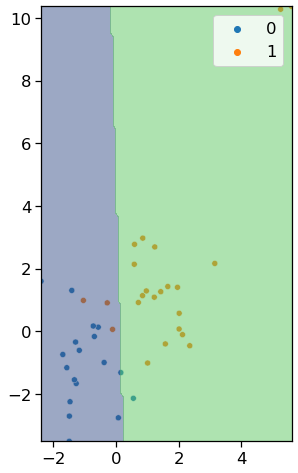

In [51]:
visualize_model(x_train, y_train, lsc)

### Gradient Descent

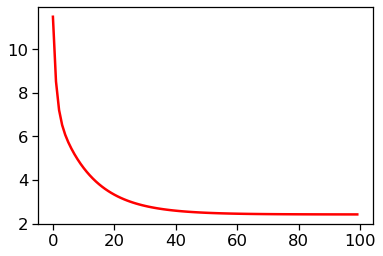

In [53]:
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 0.001)
plot_learning_curve(lsc.err_all)

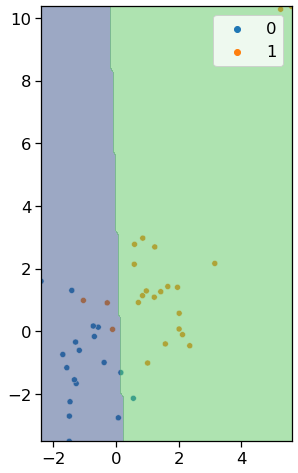

In [54]:
visualize_model(x_train, y_train, lsc)

### Stochastic Gradient Descent

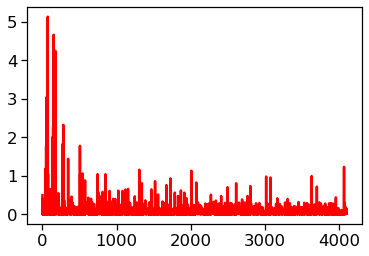

In [55]:
lsc.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc.err_all)

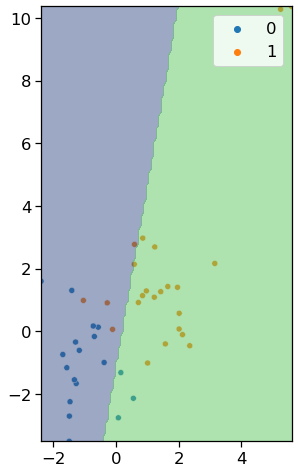

In [56]:
visualize_model(x_train, y_train, lsc)

## Classification on Data with More Than 2 Classes Per Label

In [60]:
x_train , x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_class=True)

In [61]:
assert x_train.shape[0] == y_train.shape[0], "Not enough labels for all training samples"

assert x_test.shape[0] == y_test.shape[0], "Not enough labels for all test samples"

In [62]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(56, 3) (56, 3) (3, 3)


array([[ 0.53752702,  0.28909802,  0.17337496],
       [-0.15648078,  0.14823883,  0.00824195],
       [-0.0888018 , -0.07769491,  0.16649671]])

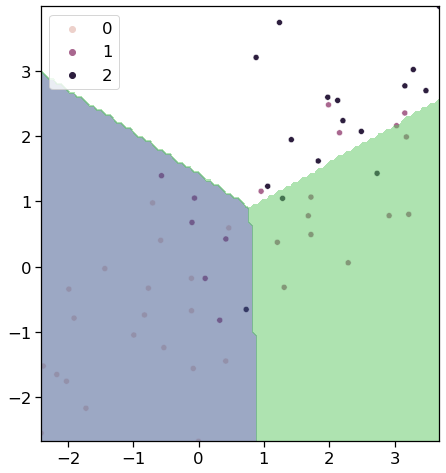

In [63]:
visualize_model(x_train, y_train, lsc)

### Gradient Descent

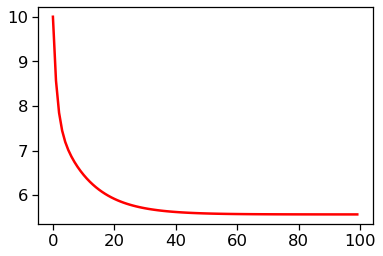

In [64]:
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr = 0.001)
plot_learning_curve(lsc.err_all)

**Using the sklearn to generate the evaluate metrics, rather than using our functions**

In [66]:
from sklearn.metrics import classification_report

y_test_predict = lsc.predict(x_test)
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.25      0.20      0.22         5
           2       0.78      0.78      0.78         9

    accuracy                           0.63        19
   macro avg       0.56      0.59      0.58        19
weighted avg       0.61      0.63      0.62        19



## Classification on Data that Fit Polynomial (Circle)

`make_circles()` - Make a large circle containing a smaller circle in 2d

In [72]:
from sklearn.datasets import make_circles
x, y = make_circles()
x[:5], y[:5]

(array([[-0.50993919,  0.61641059],
        [-0.6472136 ,  0.4702282 ],
        [ 0.42866144,  0.67546234],
        [-0.5831749 , -0.54763768],
        [ 0.72896863,  0.68454711]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [74]:
x_poly = polynomial_transform(x, degree=2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((75, 6), (25, 6), (75,), (25,))

In [75]:
y_train_trans = LabelTransformer().encode(y_train)
y_test_trans = LabelTransformer().encode(y_test)

<AxesSubplot:>

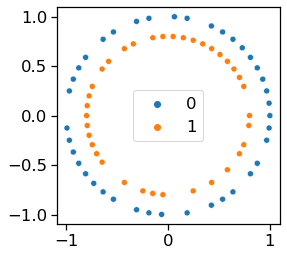

In [76]:
f = plt.figure(figsize=(4,4))
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)

In [77]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)

(75, 6) (75, 2) (6, 2)


array([[-1.77777778e+00,  2.77777778e+00],
       [-1.94733887e-16,  2.35065452e-16],
       [ 1.87616279e-16, -1.87115676e-16],
       [ 2.77777778e+00, -2.77777778e+00],
       [-1.03933750e-16, -7.10045015e-17],
       [ 2.77777778e+00, -2.77777778e+00]])

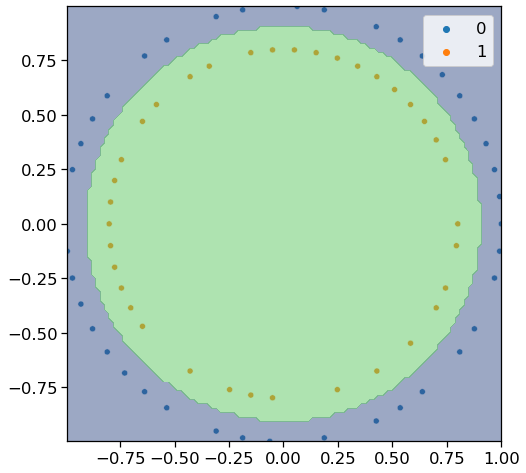

In [78]:
visualize_model(x_train, y_train, lsc, degree=2)

**Using the sklearn to generate the evaluate metrics, rather than using our functions**

In [82]:
from sklearn.metrics import classification_report

y_test_predict = lsc.predict(x_test)
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        14

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



## Appendix

In [ ]:
x0 = np.random.normal(size=50).reshape(-1,2) - 1 
print(x0.shape)

In [ ]:
x1 = np.random.normal(size=50).reshape(-1,2) + 1
x1
print(x1.shape)

In [ ]:
x_1 = np.random.normal(size=10).reshape(-1,2) + np.array([5,10])
print(x_1.shape)

In [ ]:
res = np.concatenate((x0, x1, x_1)).reshape(-1,2)
res.shape

**Axis Reference**
<img src="https://i.stack.imgur.com/gj5ue.jpg">

- `axis = 0` : **Row**
- `axis = 1` : **Column**
- `axis = -1` : **The Last Dimension**

In [ ]:
x = np.array([[4,2,3], [1,0,3], [5,6,9]])
print("ARRAY : \n", x)
indx = np.argmax(x, axis=-1)
# axis = -1 : it will be the last dimension.
print("MAX ELEMENT INDEX : ", indx)